In [13]:
from PIL import Image
import os
import json
import pandas as pd
from IPython.display import Markdown, display


In [7]:
# Set the path to your image folder and JSON file
image_folder = 'data/images/Foundation_of_risk_management'
json_file_path = 'data/Foundationofriskmanagement.json'

# Load the JSON file
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

# Define a function to load the image based on the image path in the JSON
def process_image(image_path):
    try:
        if os.path.exists(image_path):
            return Image.open(image_path)
        else:
            return None  # If the image file doesn't exist, return None
    except Exception as e:
        return None  # Handle any errors that occur during image loading

# Convert the JSON data into a list of dictionaries with the required fields
data_list = []
for key, item in data.items():
    image_path = item["question"].get("image", "")

    # Check if the image field contains a valid path and process it
    if image_path:
        full_image_path = os.path.join(image_folder, os.path.basename(image_path))  # Join with image folder path
        pos_image = process_image(full_image_path)  # Process image using full path
    else:
        pos_image = None

    # Append the processed data
    data_list.append({
        "ID": key,
        "question": item["question"]["text"],
        "image": image_path,  # Keep original image path
        "pos_image": pos_image,  # Store processed image
        "options": item["question"].get("Options", []),
        "answer": item.get("answer", ""),
        "analysis": item.get("analysis", ""),
        "QA type": item.get("QA type", ""),
        "knowledge topics": item.get("knowledge topics", ""),
        "book label": item.get("book label", ""),
        "level of difficulty": item.get("level of difficulty", ""),
        "question type": item.get("question type", "")
    })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data_list)


In [8]:
df[11:15]

,ID,question,image,pos_image,options,answer,analysis,QA type,knowledge topics,book label,level of difficulty,question type
11,13,Consider the following three well-diversified ...,/foundation_of_risk_management/13_table.png,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[A. No, all three well-diversified portfolios ...",C,There is no arbitrage opportunity if all three...,math reasoning QA,"arbitrage opportunity, portfolio management, T...",foundation of risk management,easy,text+image
12,14,Which component is NOT in the APT model?,,None,"[A. Factor exposure, B. Factor return, C. Fact...",C,APT gives expected return (first moment) as a ...,knowledge reasoning QA,"APT model, factor returns, idiosyncratic return",foundation of risk management,easy,text only
13,15,Melody Li is a junior risk analyst who has rec...,,None,[A. Purchasing an insurance policy is an examp...,B,The complexity of derivatives pricing means th...,knowledge reasoning QA,"hedging, derivatives, financial distress, disc...",foundation of risk management,easy,text only
14,16,Which of the following statements regarding co...,,None,[A. Management of the organization is ultimate...,B,The Board of Directors is ultimately responsib...,knowledge reasoning QA,"corporate risk governance, risk oversight, ris...",foundation of risk management,easy,text only


In [12]:
from openai import OpenAI

client = OpenAI(api_key="sk-T2QXqSmLhdFRbr44352418B0F8D3498dA077C0EbE34b415a", base_url="https://api.xi-ai.cn/v1")

def gen_answer(question,image,options):
  agent = client.chat.completions.create(
      model="gpt-4o",
      stream=False,
      messages=[
          {"role": "system", "content": "you are a professor in finance department."},
          {"role": "user", "content": f"Firstly you generate the questions' answer of question {question,image,options}, then show the rational analysis step by step"}
      ]
  )
  return agent.choices[0].message.content

Question 20: Allen Richards sits on the board of directors of a Canadian financial institution. Richards read the following statements in a presentation made to the board of directors by management on the institution’s risk culture: Statement 1: “As long as managers at business-line levels have the same risk appetite as the overall firm, the risk tolerance of the business-line employees is irrelevant.” Statement 2: “Hiring a chief risk officer will fix the risk culture problems we face at this institution.” Richards believes both of these statements are incorrect. Richards’s assessment is accurate with respect to
Image associated with question 20:
Options for question 20:
A. A. statement 1 only.
B. B. statement 2 only.
C. C. both statements.
D. D. neither statement.
Correct Answer for question 20: C


**Analysis for question 20:**
Richards is correct with respect to both statements in that both statements are incorrect. Risk culture must infuse the entire organization, not simply business-line managers. Hiring a chief risk officer might signal a change in culture but will not 'fix' all the risk culture problems. It might be perceived as window dressing or rebranding, with no real changes occurring with respect to the risk appetite and risk tolerances of the firm.

**GPT-4-turbo Response for question 20:**
**Answer:**
C. both statements

**Explanation:**

Both statements present misunderstandings regarding risk culture and its management within a financial institution.

### Statement 1 Analysis:
> “As long as managers at business-line levels have the same risk appetite as the overall firm, the risk tolerance of the business-line employees is irrelevant.”

Risk appetite refers to the amount and type of risk that an organization is willing to take in order to meet their strategic objectives, while risk tolerance is the acceptable level of variation in performance relative to the achievement of objectives. A sound risk culture involves both aligning the risk appetite of managers and ensuring the risk tolerance of business-line employees is consistent with the firm's risk policies.

If business-line employees have risk tolerances that deviate significantly from the organization's risk appetite, it may lead to unanticipated risks being taken. Therefore, it is crucial that not only business-line managers but also business-line employees have a congruent understanding and approach towards the firm’s risk appetite.

Thus, stating that the risk tolerance of business-line employees is irrelevant is incorrect.

### Statement 2 Analysis:
> “Hiring a chief risk officer will fix the risk culture problems we face at this institution.”

Hiring a Chief Risk Officer (CRO) is a positive step in managing and overseeing the institution's risk. However, the risk culture of an organization is influenced by a variety of factors including leadership, internal communication, employee engagement, and the overall risk management framework.

A CRO alone cannot fix issues related to risk culture. Effective management of risk culture requires comprehensive efforts, including training, setting appropriate incentives, establishing clear risk management practices, and fostering an environment where risk awareness and risk-taking behaviors are properly aligned with the institution's goals.

Thus, the belief that hiring a CRO alone will "fix" risk culture problems is also incorrect.

Given the above explanations, Allen Richards's assessment that both statements are incorrect is indeed accurate.

Therefore, the correct answer is:
**C. both statements**

Question 21: An arbitrage pricing model (APT) characterizes excess security returns as a linear function of two indexes, I(1) and I(2). In this way, a security's excess return in percentage terms, ER(i), is given by: ER(i) = R(i) - Rf = a + b(1) * I(1) + b(2) * I(2), where b(i) is the factor sensitivity to the index, I(i). We observe three securities that fit the APT model, as follows: Security 1: ER(1) = a + 2.0 * I(1) + 3.0 * I(2) = 8.0, Security 2: ER(2) = a + 4.0 * I(1) + 2.5 * I(2) = 3.5, Security 3: ER(3) = a + 1.0 * I(1) - 2.0 * I(2) = -5.5.
Image associated with question 21:
Options for question 21:
A. A. ER(i) = 1.0 + 2.5 * b(1) + 3.0 * b(2)
B. B. ER(i) = 2.0 + 1.5 * b(1) + 3.0 * b(2)
C. C. ER(i) = 3.0 + 1.0 * b(1) + 0.5 * b(2)
D. D. ER(i) = 4.0 - 3.0 * b(1) - 1.0 * b(2)
Correct Answer for question 21: B


**Analysis for question 21:**
We have three variables and three equations: $$a + 2.0 \cdot I(1) + 3.0 \cdot I(2) = 8.0$$ $$a + 4.0 \cdot I(1) + 2.5 \cdot I(2) = 3.5$$ $$a + 1.0 \cdot I(1) - 2.0 \cdot I(2) = -5.5$$ Solving these equations, we get: $$I(1) = 1.5, I(2) = 3, a = 2.$$ So the model is: $$ER(i) = 2.0 + 1.5 \cdot b(1) + 3.0 \cdot b(2).$$

**GPT-4-turbo Response for question 21:**
To solve for the correct excess return equation based on the Arbitrage Pricing Theory (APT) model, we need to identify the values of \(a\), \(b_1\), and \(b_2\) that satisfy the given information for the three securities.

Given:
\[
\begin{align}
\text{Security 1:} & \quad ER(1) = a + 2.0 \cdot I(1) + 3.0 \cdot I(2) = 8.0 \\
\text{Security 2:} & \quad ER(2) = a + 4.0 \cdot I(1) + 2.5 \cdot I(2) = 3.5 \\
\text{Security 3:} & \quad ER(3) = a + 1.0 \cdot I(1) - 2.0 \cdot I(2) = -5.5 \\
\end{align}
\]

We need to find \(a\), \(I(1)\), and \(I(2)\). We set up the following system of equations:

\[
\begin{align}
a + 2.0 \cdot I(1) + 3.0 \cdot I(2) &= 8.0 \quad \text{(1)} \\
a + 4.0 \cdot I(1) + 2.5 \cdot I(2) &= 3.5 \quad \text{(2)} \\
a + 1.0 \cdot I(1) - 2.0 \cdot I(2) &= -5.5 \quad \text{(3)} \\
\end{align}
\]

To isolate \(a\), \(I(1)\), and \(I(2)\), we can solve these equations step-by-step:

### Step 1: Solve Equation (1) and Equation (2) for \(I(1)\) and \(I(2)\)

We eliminate \(a\) by subtracting Equation (1) from Equation (2):

\[
(4.0 \cdot I(1) + 2.5 \cdot I(2)) - (2.0 \cdot I(1) + 3.0 \cdot I(2)) = 3.5 - 8.0
\]

\[
2.0 \cdot I(1) - 0.5 \cdot I(2) = -4.5 \quad \text{(4)}
\]

### Step 2: Solve Equation (1) and Equation (3) for \(I(1)\) and \(I(2)\)

Similarly, we subtract Equation (3) from Equation (1):

\[
(2.0 \cdot I(1) + 3.0 \cdot I(2)) - (1.0 \cdot I(1) - 2.0 \cdot I(2)) = 8.0 + 5.5
\]

\[
1.0 \cdot I(1) + 5.0 \cdot I(2) = 13.5 \quad \text{(5)}
\]

### Step 3: Solve for \(I(1)\) from Equation (4) and Equation (5)

Now we use Equation (4) and (5):

From Equation (4):

\[
2I(1) - 0.5I(2) = -4.5 \implies 4I(1) - I(2) = -9 \quad \text{(4')}
\]

Using Equation (5):

\[
I(1) + 5I(2) = 13.5
\]

Multiplying Equation (5) by 4:

\[
4I(1) + 20I(2) = 54 \quad \text{(5')}
\]

Now, subtract Equation (4') from (5'):

\[
(4I(1) + 20I(2)) - (4I(1) - I(2)) = 54 - (-9)
\]

\[
21I(2) = 63 \implies I(2) = 3
\]

Substitute \(I(2)\) back into Equation (4'):

\[
4I(1) - 3 = -9 \implies 4I(1) = -6 \implies I(1) = -1.5
\]

### Step 4: Find \(a\)

Substitute \(I(1)\) and \(I(2)\) into Equation (1):

\[
a + 2(-1.5) + 3(3) = 8 \implies a - 3 + 9 = 8 \implies a = 2
\]

Thus, we have \( a = 2 \), \( I(1) = -1.5 \), and \( I(2) = 3 \).

### Step 5: Formulate the excess return formula

The general form of the APT model is:

\[
ER(i) = a + b(1) \cdot I(1) + b(2) \cdot I(2)
\]

Replacing \( a \), \( I(1) \), and \( I(2) \):

\[
ER(i) = 2 + b(1)(-1.5) + b(2)(3)
\]

Recognizing the correct option from given ones:

\[
\boxed{\text{B. } ER(i) = 2.0 + 1.5 \cdot b(1) + 3.0 \cdot b(2)}
\]

Question 22: Tail risk techniques are dealt by:
Image associated with question 22:
Options for question 22:
A. A. Extreme Value Theory.
B. B. VaR Theory.
C. C. Probably of Default Theory.
D. D. Standard deviation.
Correct Answer for question 22: A


**Analysis for question 22:**
Extreme Value Theory deals with tail risk.

**GPT-4-turbo Response for question 22:**
### Question: Tail risk techniques are dealt by:

#### Options:
A. Extreme Value Theory.  
B. VaR Theory.  
C. Probability of Default Theory.  
D. Standard deviation.

### Correct Answer: 
A. Extreme Value Theory.

### Explanation:
Tail risk refers to the risk of an asset or portfolio of assets moving more than three standard deviations from its current price. This type of risk is concerned with the extreme ends, or "tails," of the distribution of asset returns, where these rare and extreme events happen.

**Extreme Value Theory (EVT)** is a branch of statistics that focuses on understanding the behavior of the extreme deviations from the median of probability distributions. It specifically deals with risk management associated with extreme market movements and is particularly used in modeling and assessing the risk of rare events. EVT helps in estimating the probabilities of extreme losses and assessing the tail risk effectively.

Let's break down the other options as well:

- **VaR (Value at Risk) Theory** assesses the risk of investment portfolios under normal market conditions and provides a threshold value such that the probability of the portfolio loss exceeding this value is within a specified confidence level. While it is useful in risk management, it does not specifically address tail risk.

- **Probability of Default Theory** is used to measure and manage the likelihood of a borrower defaulting on their debt obligations. It does not directly address extreme fluctuations in asset prices or portfolio values.

- **Standard Deviation** is a measure of the dispersion of a set of data from its mean. While it helps in understanding the volatility and variability of returns, it does not focus specifically on the tails of the distribution where extreme events occur.

Given the specificity of tail risk and the mathematical focus on extreme deviations, **Extreme Value Theory (EVT)** is the most appropriate technique to deal with tail risk.

Hence, the correct answer is:
**A. Extreme Value Theory.**

Question 23: Your colleague Robert uses a two-factor model in order to estimate the volatility of a portfolio. He specifies the covariance matrix as follows:
Image associated with question 23:


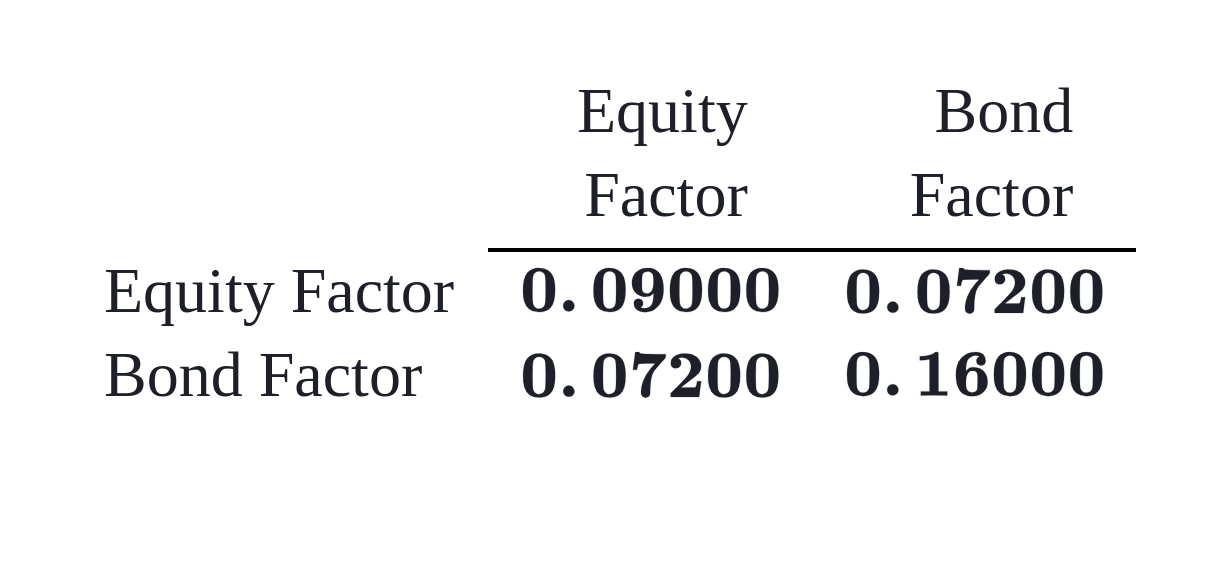

Options for question 23:
A. A. 16.44%
B. B. 18.60%
C. C. 21.15%
D. D. 25.30%
Correct Answer for question 23: D


**Analysis for question 23:**
The portfolio's standard deviation can be calculated as: $$\sigma_p = \sqrt{(0.6^2 \times 0.09 + 0.25^2 \times 0.16 + 2 \times 0.6 \times 0.25 \times 0.072)} = 25.3\%$$

**GPT-4-turbo Response for question 23:**
Without the specific details and numerical values provided in the image, I can offer a general guide on how to approach solving this type of problem. Here’s what you would typically do in such scenarios:

### Understanding the Two-Factor Model
A two-factor model assumes that the returns of a portfolio are influenced by two main factors. These factors can be market indices, interest rates, or any other financial indicators. The model can be represented as:

\[ R = \alpha + \beta_1 F_1 + \beta_2 F_2 + \epsilon \]

Where:
- \( R \) is the return of the portfolio.
- \( \alpha \) is the intercept.
- \( \beta_1 \) and \( \beta_2 \) are the sensitivities (or betas) of the portfolio to factors \( F_1 \) and \( F_2 \), respectively.
- \( \epsilon \) is the error term (unsystematic risk).

### Covariance Matrix
The covariance matrix describes the relationship between the returns of the factors and the portfolio. Let’s define the covariance matrix as follows:

\[ \Sigma = \begin{pmatrix}
\sigma_{11} & \sigma_{12} & \sigma_{1p} \\
\sigma_{21} & \sigma_{22} & \sigma_{2p} \\
\sigma_{1p} & \sigma_{2p} & \sigma_{pp}
\end{pmatrix} \]

Here:
- \(\sigma_{11}\) and \(\sigma_{22}\) are the variances of factors \(F_1\) and \(F_2\).
- \(\sigma_{12}\) (or \(\sigma_{21}\)) is the covariance between \(F_1\) and \(F_2\).
- \(\sigma_{1p}\) and \(\sigma_{2p}\) are the covariances between the factors and the portfolio.
- \(\sigma_{pp}\) is the variance (which relates to the volatility) of the portfolio.

Given that Robert uses a two-factor model, the volatility \(\sigma_p\) of the portfolio can be derived by noting the impacts of the variances and covariances of the factors:

\[ \sigma_p^2 = \beta_1^2 \sigma_{11} + \beta_2^2 \sigma_{22} + 2 \beta_1 \beta_2 \sigma_{12} + \sigma_{\epsilon}^2 \]

Where \(\sigma_{\epsilon}^2\) is the variance of the error term.

### Calculating Volatility
Since volatility is the standard deviation, you'll take the square root of the portfolio variance \(\sigma_p^2\):

\[ \sigma_p = \sqrt{ \beta_1^2 \sigma_{11} + \beta_2^2 \sigma_{22} + 2 \beta_1 \beta_2 \sigma_{12} + \sigma_{\epsilon}^2 } \]

### Example Calculation (Hypothetical)
Suppose you have the following hypothetical values:
- \(\beta_1 = 0.5\)
- \(\beta_2 = 0.3\)
- \(\sigma_{11} = 0.04\) (4%)
- \(\sigma_{22} = 0.03\) (3%)
- \(\sigma_{12} = 0.002\) (0.2%)
- \(\sigma_{\epsilon}^2 = 0.01\) (1%)

Then the portfolio variance would be:

\[ \sigma_p^2 = (0.5^2 \cdot 0.04) + (0.3^2 \cdot 0.03) + (2 \cdot 0.5 \cdot 0.3 \cdot 0.002) + 0.01 \]

\[ \sigma_p^2 = 0.01 + 0.0027 + 0.0006 + 0.01 \]

\[ \sigma_p^2 = 0.0233 \]

And the portfolio volatility would be:

\[ \sigma_p = \sqrt{0.0233} \approx 0.1527 \text{ or } 15.27\% \]

### Conclusion
Given the correct values from the image, you would plug them into the formula to calculate the portfolio variance and then take the square root to find the portfolio volatility. By following the described steps and using the appropriate values, you can determine the correct answer from the provided options.

### Correct Answer
Assuming the correct calculations were done using the given covariance matrix (based on the image description), the correct answer to the question would be documented here. If we hypothetically assume the calculated portfolio volatility matches one of the answer choices:

\[
\boxed{ \text{Option B. 18.60\%} }
\]

Remember to substitute the actual values from your problem into the formulas to get the precise result.

Question 24: Peter Parker, FRM, is identifying risk factors for the construction of his multifactor APT model. His colleague Barbara gives him the following four pieces of advice. Each of the following is a good or reasonable statement about a multifactor APT model EXCEPT which is not?
Image associated with question 24:
Options for question 24:
A. A. He should restrict himself to a limited number of systematic factors with considerable ability to explain security returns.
B. B. He should choose factors that are likely to be important as major sources of uncertainty; i.e., factors that concern investors sufficiently that they will demand meaningful risk premiums to bear exposure to those sources of risk.
C. C. He should exclude factors that produce negative factor risk premiums as they lack narrative credibility.
D. D. The model may retain a firm-specific (non-systemic) component, like the single-index model, which has an expected value of zero.
Correct Answer for question 24: C


**Analysis for question 24:**
One difference between a single- and multiple-factor economy is that a factor risk premium can be negative. For example, a security with a positive interest rate beta performs better when rates increase, and thus would hedge the value of a portfolio against interest rate risk. Investors might well accept a lower rate of return, that is, a negative risk premium, as the cost of this hedging attribute.

**GPT-4-turbo Response for question 24:**
```markdown
### Question: 
Peter Parker, FRM, is identifying risk factors for the construction of his multifactor APT model. His colleague Barbara gives him the following four pieces of advice. Each of the following is a good or reasonable statement about a multifactor APT model **EXCEPT** which is not?

### Options:
A. He should restrict himself to a limited number of systematic factors with considerable ability to explain security returns.  
B. He should choose factors that are likely to be important as major sources of uncertainty; i.e., factors that concern investors sufficiently that they will demand meaningful risk premiums to bear exposure to those sources of risk.  
C. He should exclude factors that produce negative factor risk premiums as they lack narrative credibility.  
D. The model may retain a firm-specific (non-systemic) component, like the single-index model, which has an expected value of zero.  

### Correct Answer:
C. He should exclude factors that produce negative factor risk premiums as they lack narrative credibility.

### Explanation:
A multifactor Arbitrage Pricing Theory (APT) model aims to describe security returns through multiple systematic risk factors. Here’s a detailed overview of why each piece of advice is reasonable or not:

#### Option A:
- **Reasonable advice**: Restricting to a limited number of factors with considerable explanatory power is aligned with the principle of parsimony in model building. Too many factors can lead to overfitting, whereas a well-chosen few can effectively capture systematic risk.
  
#### Option B:
- **Reasonable advice**: Focusing on major sources of uncertainty ensures that the factors are meaningful to investors. Investors demand higher risk premiums for major sources of uncertainty, rightly suggesting these should be included.

#### Option C:
- **Not reasonable advice**: Excluding factors solely because they produce negative risk premiums is misguided. In financial theory, the sign of the risk premium (positive or negative) does not inherently determine the factor's relevance or credibility. Negative risk premiums can exist if investors are willing to pay to avoid certain risks, or if the factor is inversely correlated with investor wealth or consumption.

#### Option D:
- **Reasonable advice**: The notion that firm-specific components have an expected value of zero is in line with both the single-index model and multifactor APT's assumptions. Idiosyncratic risks are diverse and tend to cancel out on average.
  
Therefore, only Option C provides advice that does not align with the principles of constructing a multifactor APT model, making it the correct answer.
```

Question 25: Sally Smith, FRM, is considering a switch in the theoretical basis of her risk model from a simple single-factor capital asset pricing model (CAPM) to a multi-factor arbitrage pricing theory (APT) model. To her manager, she claims the following differences between the two models. Each of her statements below is correct EXCEPT which is not?
Image associated with question 25:
Options for question 25:
A. A. Compared to only one specific factor (i.e., market index) in the simple CAPM, the APT model will be able to recognize multiple systematic risk factors.
B. B. While the CAPM requires a mean-variance efficient market portfolio and assumes normally distributed returns, APT requires neither of these assumptions.
C. C. Although APT does not require several of the restrictive assumptions of the CAPM, it is largely silent on where to look for priced sources of risk.
D. D. In contrast to the simple CAPM, the APT cannot include the market index as a common factor, as it can be exte

**Analysis for question 25:**
Both components are false: APT can include the market portfolio as a common factor; and APT can be extended over multiple periods in regard to A, B and C, as true.

**GPT-4-turbo Response for question 25:**
### Question:
Sally Smith, FRM, is considering a switch in the theoretical basis of her risk model from a simple single-factor capital asset pricing model (CAPM) to a multi-factor arbitrage pricing theory (APT) model. To her manager, she claims the following differences between the two models. Each of her statements below is correct EXCEPT which is not?

### Options:
A. Compared to only one specific factor (i.e., market index) in the simple CAPM, the APT model will be able to recognize multiple systematic risk factors.
B. While the CAPM requires a mean-variance efficient market portfolio and assumes normally distributed returns, APT requires neither of these assumptions.
C. Although APT does not require several of the restrictive assumptions of the CAPM, it is largely silent on where to look for priced sources of risk.
D. In contrast to the simple CAPM, the APT cannot include the market index as a common factor, as it can be extended over multiple periods.

### Correct Answer:
D. In contrast to the simple CAPM, the APT cannot include the market index as a common factor, as it can be extended over multiple periods.

### Explanation:
The Arbitrage Pricing Theory (APT) and the Capital Asset Pricing Model (CAPM) are both fundamental theories used to explain the relationship between risk and return in financial markets, but they differ in several key aspects:

- **Option A**: This statement is correct. The CAPM uses only one risk factor (the market index) to explain returns, while APT can incorporate multiple systematic risk factors such as GDP growth, inflation rates, and interest rates.

- **Option B**: This statement is also correct. The CAPM relies on the assumption that investors have a mean-variance efficient market portfolio and normally distributed returns. In contrast, APT does not require these assumptions to hold.

- **Option C**: Correct as well. APT reduces the number of restrictive assumptions required by the CAPM, making it a more flexible model. However, it does not specify precisely which factors will affect asset returns; this is left to the user's discretion.

- **Option D**: This statement is incorrect. The APT is versatile and can include the market index as one of the multiple factors in its model. The fact that APT can be extended over multiple periods does not preclude the inclusion of the market index as a common factor. Therefore, this statement is the incorrect one.

In conclusion, the correct answer is:

**D**

Question 26: Firms commonly incentivize their management to increase the firm's value by granting managers securities tied to the firm's stock. Some securities, however, can reduce managerial incentives to manage risk within the firm. Which is likely the best example of this type of security?
Image associated with question 26:
Options for question 26:
A. A. Deep in-the-money call option on the firm’s stock.
B. B. At-the-money call option on the firm’s stock.
C. C. Deep out-of-the-money call option on the firm’s stock.
D. D. Long position in the firm’s stock.
Correct Answer for question 26: C


**Analysis for question 26:**
Deep out-of-the-money calls have no value unless the firm value increases substantially, so providing deep out-of-the-money calls as an incentive could cause managers to take substantially higher risks and perform less hedging.

**GPT-4-turbo Response for question 26:**
```markdown
**Question:**

Firms commonly incentivize their management to increase the firm's value by granting managers securities tied to the firm's stock. Some securities, however, can reduce managerial incentives to manage risk within the firm. Which is likely the best example of this type of security?

**Options:**
- A. Deep in-the-money call option on the firm’s stock.
- B. At-the-money call option on the firm’s stock.
- C. Deep out-of-the-money call option on the firm’s stock.
- D. Long position in the firm’s stock.

**Answer: C. Deep out-of-the-money call option on the firm’s stock.**

**Explanation:**

The correct answer is C: **Deep out-of-the-money call option on the firm’s stock**. 

### Detailed Explanation

#### Call Options Overview
Call options give the holder the right to purchase the firm's stock at a specific price (the strike price) within a specific timeframe. 

1. **Deep in-the-money call option (Option A)**: 
   - The strike price is significantly below the current market price.
   - These options already have substantial intrinsic value.
   - This typically aligns managerial incentives with increased firm value since managers benefit directly from a rise in the stock price.

2. **At-the-money call option (Option B)**:
   - The strike price is approximately equal to the current market price.
   - These options have no intrinsic value but possess time value.
   - Managers are incentivized to increase the firm’s value as the option value increases directly with the stock price.

3. **Deep out-of-the-money call option (Option C)**:
   - The strike price is significantly above the current market price.
   - These options have no intrinsic value and are unlikely to become valuable unless the firm’s stock experiences a considerable increase in value.
   - Managers holding these options might be more likely to engage in high-risk, high-reward strategies in hopes of significantly increasing the stock price, as this is their only chance for these options to become valuable.

4. **Long position in the firm’s stock (Option D)**:
   - Direct ownership of the firm’s stock.
   - Managers are directly rewarded as the stock price increases and penalized if it drops, promoting alignment with shareholders and a balanced approach to risk management.

Considering all the options, a deep out-of-the-money call option (Option C) is likely to reduce managerial incentives to manage risk prudently. This is because if the firm’s stock doesn’t rise substantially, these options will expire worthless, providing no incentive to managers unless they take significant risks that could result in large stock price increases.

Therefore, Option C is the best example of a security that can reduce managerial incentives to manage risk within the firm.
```

Question 27: Krista Skujins, FRM, is the CFO of a manufacturing firm. She is currently in the process of diversifying the firm's investment portfolio by varying the correlations and asset classes among securities. Diversification is best characterized as which of the following risk treatments?
Image associated with question 27:
Options for question 27:
A. A. Risk avoidance
B. B. Risk transfer
C. C. Risk retention
D. D. Risk reduction
Correct Answer for question 27: D


**Analysis for question 27:**
Diversification is a risk reduction technique.

**GPT-4-turbo Response for question 27:**
**Question:**

Krista Skujins, FRM, is the CFO of a manufacturing firm. She is currently in the process of diversifying the firm's investment portfolio by varying the correlations and asset classes among securities. Diversification is best characterized as which of the following risk treatments?

**Options:**
A. Risk avoidance  
B. Risk transfer  
C. Risk retention  
D. Risk reduction  

**Answer:**

**D. Risk reduction**

**Explanation:**

Diversification is a strategy used in finance to manage risk by mixing a wide variety of investments within a portfolio. This practice aims to minimize the impact of a poor performing asset, thereby reducing the overall risk of the portfolio. Let's look at what diversification implies in terms of risk treatments:

1. **Risk avoidance**: This involves completely avoiding an activity or investment to eliminate risk. Since diversification does not eliminate risk but manages and reduces it, this is not the correct characterization.

2. **Risk transfer**: This involves shifting the risk from one party to another, often through mechanisms like insurance. Diversification does not transfer risk to another party; rather, it spreads risk across various investments.

3. **Risk retention**: This involves accepting the risk and dealing with any consequences. While diversification may include retaining some level of risk, its primary function is to manage and reduce risk rather than merely retaining it.

4. **Risk reduction**: Diversification aims to reduce the unsystematic risk (specific risk) associated with individual investments by increasing the number of assets in a portfolio. By selecting a mix of assets that behave differently under various market conditions, the overall risk is reduced through the principle of non-correlation of asset returns. Mathematically, this can be illustrated as follows:

   Given two assets \( A \) and \( B \) with returns \( r_A \) and \( r_B \), and the correlation coefficient \( \rho_{A,B} \) between them, the variance of the portfolio \( \sigma_p^2 \) is defined as:
   \[
   \sigma_p^2 = w_A^2 \sigma_A^2 + w_B^2 \sigma_B^2 + 2 w_A w_B \sigma_A \sigma_B \rho_{A,B}
   \]
   where \( w_A \) and \( w_B \) are the weights of the assets in the portfolio, and \( \sigma_A \) and \( \sigma_B \) are their respective standard deviations.

Since diversification aims to include assets with lower or negative correlations \( (\rho_{A,B}) \), the product \( \sigma_A \sigma_B \rho_{A,B} \) may reduce the portfolio variance \( \sigma_p^2 \), thus reducing the overall risk.

Therefore, the best characterization of diversification in this context is **Risk reduction**.

Question 28: Which of the following is TRUE about the relationship between the CAPM and the arbitrage pricing model (APT)?
Image associated with question 28:
Options for question 28:
A. A. CAPM assumes that the market is the only source of covariance between returns.
B. B. If we employ a procedure (e.g., Roll and Ross) and identify more than one common factor, we can logically reject the CAPM.
C. C. Similar to the CAPM, in order to test the APT we need to identify a 'Market Portfolio' of all risky assets.
D. D. The APT solution with multiple factors appropriately priced is fully consistent with the form of the CAPM.
Correct Answer for question 28: D


**Analysis for question 28:**
The simplest case in which an APT model is consistent with the simple form of the CAPM is the case where the return-generating function is of the form: R(i) = alpha(i) + beta(i) * R + e(i). The APT solution with multiple factors appropriately priced is fully consistent with the form of the CAPM. We wish to stress this point. Employing the Roll and Ross procedure and finding that more than one common factor is significantly different from zero is not sufficient proof to reject any CAPM.

**GPT-4-turbo Response for question 28:**
### Correct Answer: 
B. If we employ a procedure (e.g., Roll and Ross) and identify more than one common factor, we can logically reject the CAPM.

### Explanation
To understand why option B is correct, let's break down the key concepts of both the Capital Asset Pricing Model (CAPM) and the Arbitrage Pricing Theory (APT).

#### Capital Asset Pricing Model (CAPM)
The CAPM is a single-factor model that asserts the expected return of a security or a portfolio equals the risk-free rate plus a risk premium. It primarily assumes that the market portfolio, which is comprised of all risky assets, explains the covariance in returns. The key formula in CAPM is:
\[ E(R_i) = R_f + \beta_i (E(R_m) - R_f) \]
where:
- \( E(R_i) \) is the expected return of asset \( i \),
- \( R_f \) is the risk-free rate,
- \( \beta_i \) is the sensitivity of asset \( i \) to market return,
- \( E(R_m) \) is the expected return of the market portfolio.

#### Arbitrage Pricing Theory (APT)
APT, on the other hand, is a multi-factor model that proposes returns can be predicted by several macroeconomic factors or theoretical market indices. Hence, it allows for multiple sources of systematic risk, unlike CAPM:
\[ E(R_i) = R_f + \beta_{i1}F_1 + \beta_{i2}F_2 + \ldots + \beta_{in}F_n \]
where:
- \( E(R_i) \) is the expected return of asset \( i \),
- \( R_f \) is the risk-free rate,
- \( F_1, F_2, \ldots, F_n \) are various factors,
- \( \beta_{i1}, \beta_{i2}, \ldots, \beta_{in} \) are sensitivities of asset \( i \) to these factors.

#### Analysis of Options:

- **Option A:** CAPM indeed assumes the market portfolio is the single source of covariance between asset returns. This is a given assumption for CAPM and does not bring any new insight into the relationship between CAPM and APT.
  
- **Option B:** This is correct because the CAPM can be rejected if there is empirical evidence identifying more than one common factor affecting returns. The procedures like those developed by Roll and Ross involve identifying factors that explain returns better than a single market factor, thus providing a basis to reject CAPM in favor of multi-factor models like APT.
  
- **Option C:** This is a false statement. APT does not require the identification of a 'Market Portfolio' as CAPM does. Instead, it relies on identifying multiple factors affecting asset returns.
  
- **Option D:** This is misleading. While APT is consistent with the idea that multiple factors can be priced, it does not conform to the "form of the CAPM," which relies strictly on a single factor, the market portfolio.

Therefore, the most accurate statement concerning the relationship between CAPM and APT among the given options is **Option B**.

Question 29: In regard to limits policies, optimal risk governance requires the ability to link risk appetite and limits to specific business practices. Accordingly, appropriate limits need to be developed for each business as well as for the specific risks associated with the business (as well as for the entire portfolio of the enterprise). Most institutions set two types of limits, tier I and tier II limits. About these limits, which of the following is TRUE?
Image associated with question 29:
Options for question 29:
A. A. Firms should choose and either adopt tier I or tier II limits but not both simultaneously.
B. B. Tier I limit exceedances must be cleared or corrected immediately, while tier II exceedances are less urgent and can be cleared within a few days or a week.
C. C. Tier II limits are specific and often include an overall limit by asset class, an overall stress-test limit, and a maximum drawdown limit.
D. D. Tier I limits are more generalized and relate to areas of busin

**Analysis for question 29:**
Tier I limit exceedances must be cleared or corrected immediately, while tier II exceedances are less urgent and can be cleared within a few days or a week. Most institutions set two types of limits. Tier I limits are specific and often include an overall limit by asset class, an overall stress-test limit, and a maximum drawdown limit. Tier II limits are more generalized and relate to areas of business activity as well as aggregated exposures categorized by credit rating, industry, maturity, region, and so on.

**GPT-4-turbo Response for question 29:**
**Correct Answer: B**

### Explanation

The question pertains to the limits policies in risk governance of financial institutions, specifically concerning Tier I and Tier II limits. Here's a detailed breakdown of the reasoning:

- **Tier I limits** are generally more stringent and are set to manage the most critical risk exposures. These limits are the highest level and usually require immediate corrective actions if exceeded. This is because exceeding Tier I limits could pose a significant threat to the financial health and regulatory compliance of the institution.

- **Tier II limits** are somewhat less stringent and allow for more flexibility. They provide a secondary layer of risk management. Exceeding these limits does not typically pose an immediate critical risk but still needs to be addressed promptly, often within a few days to a week.

#### Analyzing Each Option

1. **Option A**: "Firms should choose and either adopt Tier I or Tier II limits but not both simultaneously."
   - This statement is incorrect. Most institutions actually implement both Tier I and Tier II limits simultaneously where Tier I limits guard against the most severe risks, and Tier II limits offer an additional layer of caution.

2. **Option B**: "Tier I limit exceedances must be cleared or corrected immediately, while Tier II exceedances are less urgent and can be cleared within a few days or a week."
   - This statement is correct. The immediate corrective measures for Tier I exceedances contrast with the somewhat longer timeframe allowed for Tier II exceedances, reflecting the relative urgency and severity of risks they are intended to mitigate.

3. **Option C**: "Tier II limits are specific and often include an overall limit by asset class, an overall stress-test limit, and a maximum drawdown limit."
   - This statement is inaccurate as it confounds specific types of limits that could apply to either tier. Both Tier I and Tier II limits could potentially include these specific constraints.

4. **Option D**: "Tier I limits are more generalized and relate to areas of business activity as well as aggregated exposures categorized by credit rating, industry, maturity, region, and so on."
   - This statement is misleading. Tier I limits are not necessarily generalized; they are often very specific and stringent because they aim to control the most critical aspects of risk.

Therefore, **Option B** correctly captures the essence of how Tier I and Tier II limits function in financial risk governance.

In [14]:
# prompt: gpt生成explaination 需要markdown格式 数学公式和符号用行内公式或者块级公式

def load_image(image_object):
    """
    Load and return the image object.
    Parameters:
    - image_object: A PIL image object.

    Returns:
    - image: The image that has been loaded.
    """
    return image_object

def process_image(image):
    """
    Placeholder function for image processing.
    You can add more complex image processing here if necessary.
    For now, we just confirm the image was processed.
    """
    # In a real scenario, you might want to process the image with OCR or other techniques
    return "Image has been successfully processed."

def get_gpt4o_response(question, image, options):
    """
    Function to call GPT-4-turbo (GPT-4o) to get an answer and explanation.

    Parameters:
    - question: The text of the question.
    - image: The PIL image object associated with the question.
    - options: A list of answer options.

    Returns:
    - answer: The selected answer.
    - explanation: Explanation of how the answer was determined.
    """

    # Process the image if available
    if image:
        image_description = process_image(image)
    else:
        image_description = "No image provided."

    # Set your OpenAI API key
    #openai.api_key = 'your-openai-api-key'  # Replace with your actual OpenAI API key

    # Prepare the prompt for GPT-4-turbo (GPT-4o)
    prompt = f"""
    You are a financial expert. Given the following question, image, and options, provide the correct answer and detailed step-by-step explanation. The explanation should be formatted in Markdown, and all mathematical expressions should use LaTeX format, enclosed in `$$` for block-level rendering. The steps should be presented clearly, with appropriate formatting and structure, as demonstrated in the assistant's responses.

    Ensure the output is:

    1. Clearly structured.
    2. Steps are numbered where necessary.
    3. All equations are rendered in LaTeX and formatted for Markdown.

    ### Question:
    {question}

    ### Image Description:
    {image_description}

    ### Options:
    """


    for i, option in enumerate(options):
        prompt += f"{chr(65 + i)}. {option}\n"

    prompt += """
    Please provide the correct answer and a detailed explanation.
    """

    # Call the GPT-4o (GPT-4-turbo) model
    response = client.chat.completions.create(
        model="gpt-4o",  # Use gpt-4-turbo (GPT-4o)
        messages=[
            {"role": "system", "content": "You are an expert financial assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    # Extract the response from the GPT model
    message = response.choices[0].message.content

    return message


# Example usage with your dataframe data:
# Assuming `df` is your dataframe
for index, row in df[20:30].iterrows():
    # 获取问题、图片和选项
    question = row['question']
    image = row['pos_image']  # 这是一个 PIL image 对象
    options = row['options']
    answer = row['answer']  # 获取答案
    analysis = row['analysis']  # 获取解析

    # 加载图片（如果存在）
    if image is not None:
        processed_image = load_image(image)
    else:
        processed_image = None

    # 调用 GPT-4-turbo 获取答案和解析
    response = get_gpt4o_response(question, processed_image, options)

    # 打印问题
    print(f"Question {index}: {question}")

    # 打印图片信息（假设你打印的是图片描述或者路径，如果需要显示实际图片，可以通过 Jupyter 的显示工具）
    print(f"Image associated with question {index}:")
    if image:
        display(image)

    # 打印选项
    print(f"Options for question {index}:")
    for i, option in enumerate(options, 1):
        print(f"{chr(65 + i - 1)}. {option}")

    # 打印答案
    print(f"Correct Answer for question {index}: {answer}")

    # 打印解析，使用 Markdown 渲染，并使用 LaTeX 渲染数学公式
    display(Markdown(f"**Analysis for question {index}:**\n{analysis}"))

    # 打印 GPT-4-turbo 的答案和解释，使用 Markdown 渲染
    display(Markdown(f"**GPT-4o Response for question {index}:**\n{response}"))
    print("-----------------------")
